In [98]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from IPython.display import display, HTML

In [99]:
# Set plot styles and ignore warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set(style="whitegrid")
%matplotlib inline

In [100]:
# Display settings for better visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [101]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [102]:
# Save the PassengerId for submission file
passenger_id = test_data['PassengerId']

print(f"Training set shape: {train_data.shape}")
print(f"Test set shape: {test_data.shape}")

Training set shape: (891, 12)
Test set shape: (418, 11)


In [103]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [104]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [105]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [106]:
missing_train = train_data.isnull().sum().sort_values(ascending=False)
missing_test = test_data.isnull().sum().sort_values(ascending=False)
missing_percent_train = (missing_train / len(train_data)) * 100
missing_percent_test = (missing_test / len(test_data)) * 100

missing_data_train = pd.concat([missing_train, missing_percent_train], axis=1, 
                              keys=['Total', 'Percent'])
missing_data_test = pd.concat([missing_test, missing_percent_test], axis=1, 
                             keys=['Total', 'Percent'])

print("Missing values in training data:")
display(missing_data_train)
print("\nMissing values in test data:")
display(missing_data_test)

Missing values in training data:


,Total,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
SibSp,0,0.000000
Parch,0,0.000000



Missing values in test data:


,Total,Percent
Cabin,327,78.229665
Age,86,20.574163
Fare,1,0.239234
PassengerId,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000


In [107]:
# Exploratory Data Analysis (EDA) section

Overall survival rate: 38.38%


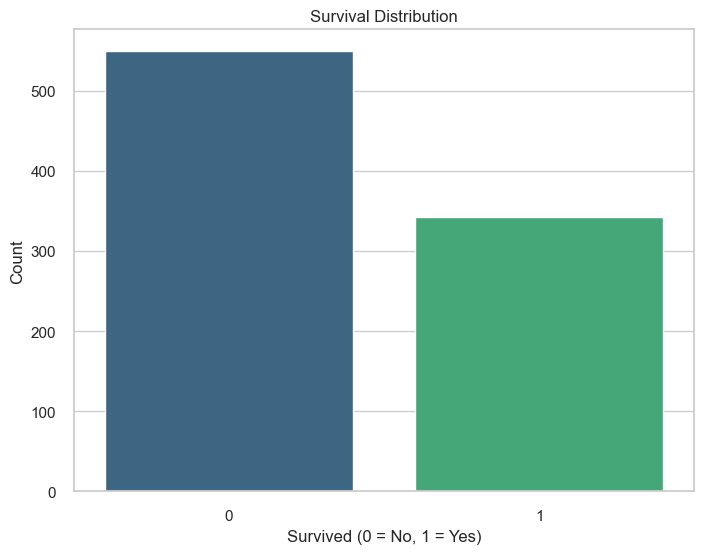

In [108]:
# 1. Survival rate analysis
display(HTML("<h3>Overall Survival Rate</h3>"))
survival_rate = train_data['Survived'].mean() * 100
print(f"Overall survival rate: {survival_rate:.2f}%")

plt.figure(figsize=(8, 6))
sns.countplot(x='Survived', data=train_data, palette='viridis')
plt.title('Survival Distribution')
plt.ylabel('Count')
plt.xlabel('Survived (0 = No, 1 = Yes)')
plt.show()

Female survival rate: 74.20%
Male survival rate: 18.89%


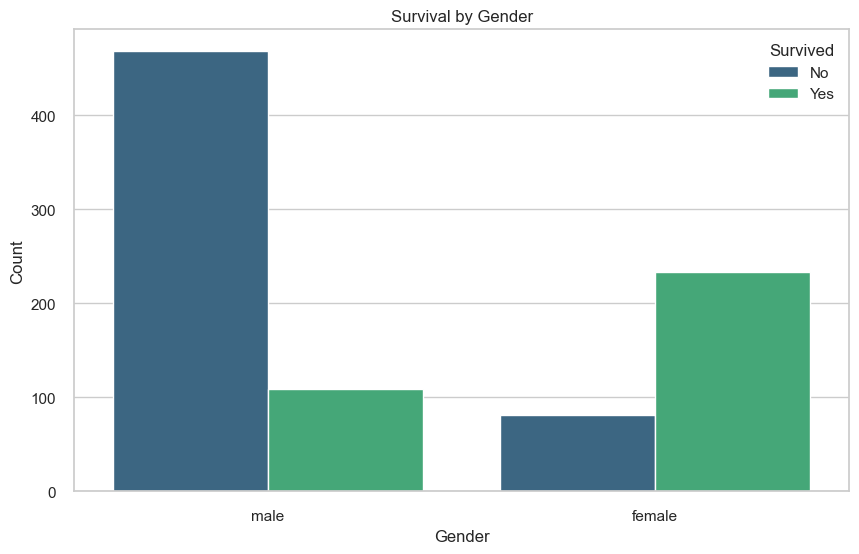

In [109]:
# 2. Gender analysis
display(HTML("<h3>Survival by Gender</h3>"))
gender_survival = train_data.groupby('Sex')['Survived'].mean() * 100
print(f"Female survival rate: {gender_survival['female']:.2f}%")
print(f"Male survival rate: {gender_survival['male']:.2f}%")

plt.figure(figsize=(10, 6))
sns.countplot(x='Sex', hue='Survived', data=train_data, palette='viridis')
plt.title('Survival by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.show()

1st class survival rate: 62.96%
2nd class survival rate: 47.28%
3rd class survival rate: 24.24%


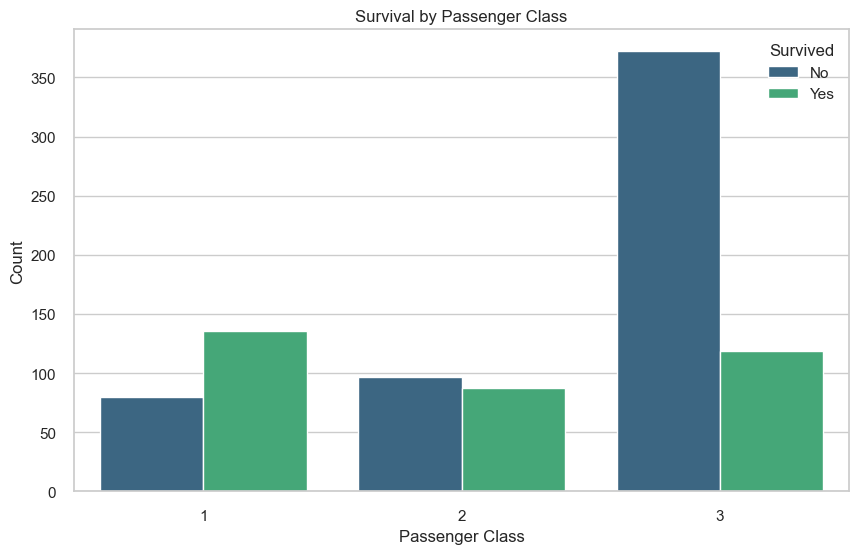

In [110]:
# 3. Class analysis
display(HTML("<h3>Survival by Passenger Class</h3>"))
class_survival = train_data.groupby('Pclass')['Survived'].mean() * 100
print(f"1st class survival rate: {class_survival[1]:.2f}%")
print(f"2nd class survival rate: {class_survival[2]:.2f}%")
print(f"3rd class survival rate: {class_survival[3]:.2f}%")

plt.figure(figsize=(10, 6))
sns.countplot(x='Pclass', hue='Survived', data=train_data, palette='viridis')
plt.title('Survival by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Count')
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.show()

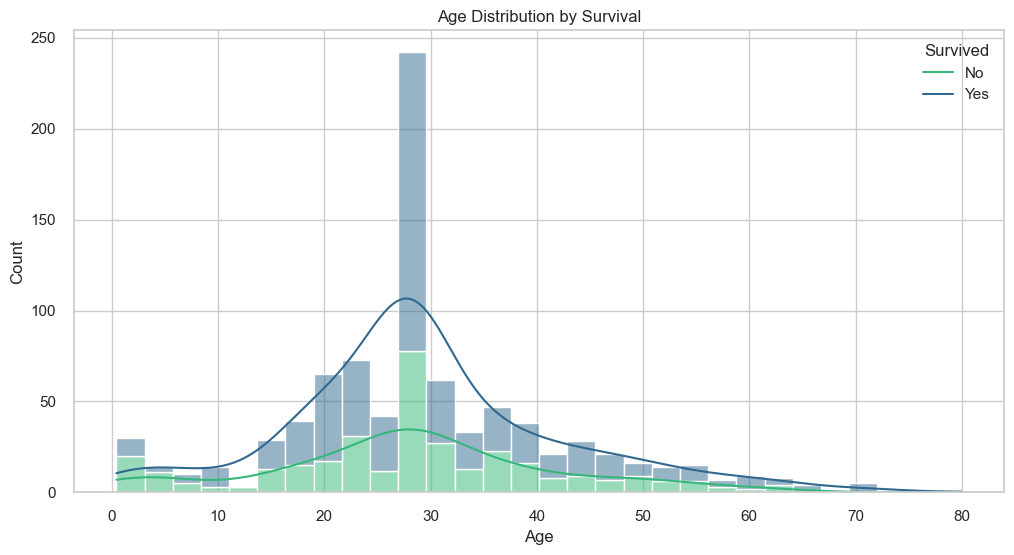

In [111]:
# 4. Age analysis - Distribution and survival correlation
display(HTML("<h3>Age Distribution and Survival Correlation</h3>"))

# Fill missing ages with median
train_data_age = train_data.copy()
train_data_age['Age'].fillna(train_data['Age'].median(), inplace=True)

plt.figure(figsize=(12, 6))
sns.histplot(data=train_data_age, x='Age', hue='Survived', kde=True, multiple='stack', palette='viridis')
plt.title('Age Distribution by Survival')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.show()

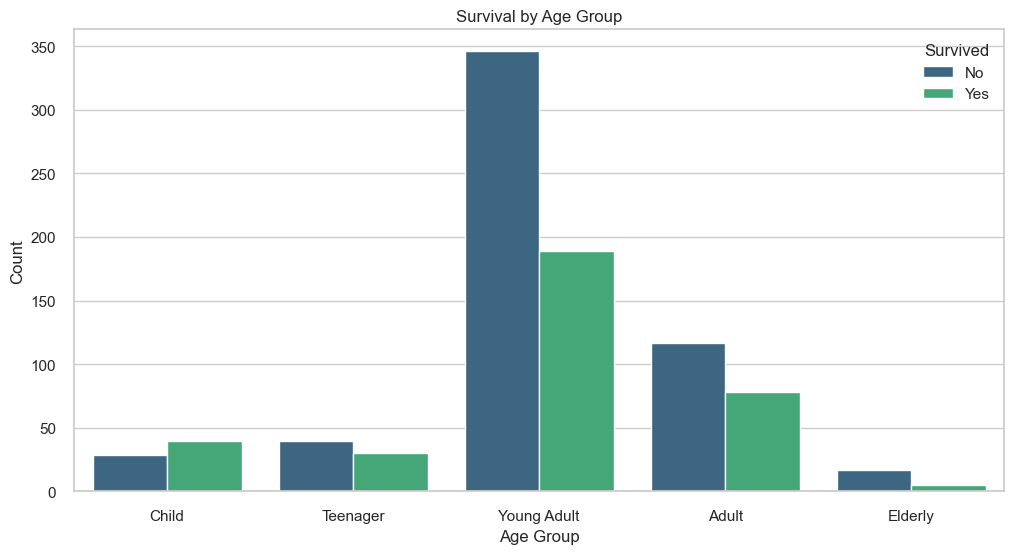

In [112]:
# Create age groups for better analysis
train_data_age['Age_Group'] = pd.cut(train_data_age['Age'], 
                                    bins=[0, 12, 18, 35, 60, 100], 
                                    labels=['Child', 'Teenager', 'Young Adult', 'Adult', 'Elderly'])

plt.figure(figsize=(12, 6))
sns.countplot(x='Age_Group', hue='Survived', data=train_data_age, palette='viridis')
plt.title('Survival by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.show()

In [113]:
age_group_survival = train_data_age.groupby('Age_Group')['Survived'].mean() * 100
print("Survival rate by age group:")
for age_group, rate in age_group_survival.items():
    print(f"{age_group}: {rate:.2f}%")

Survival rate by age group:
Child: 57.97%
Teenager: 42.86%
Young Adult: 35.33%
Adult: 40.00%
Elderly: 22.73%


In [114]:
# 5. Family size analysis
display(HTML("<h3>Family Size and Survival Rate</h3>"))
# Create family size feature
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1  # +1 for the passenger

# Group by family size
family_survival = train_data.groupby('FamilySize')['Survived'].mean() * 100
print("Survival rate by family size:")
display(family_survival)



Survival rate by family size:


FamilySize
1     30.353818
2     55.279503
3     57.843137
4     72.413793
5     20.000000
6     13.636364
7     33.333333
8      0.000000
11     0.000000
Name: Survived, dtype: float64

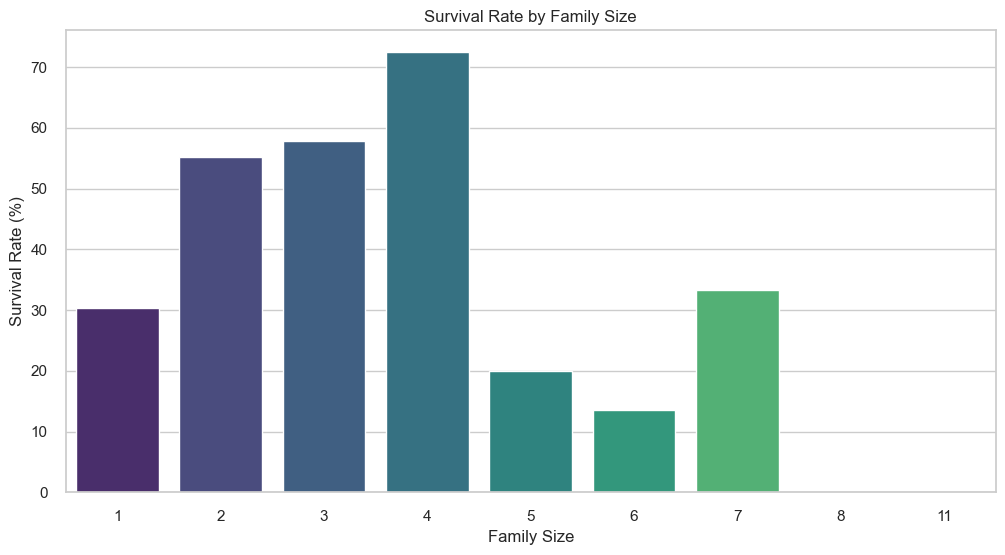

In [115]:
plt.figure(figsize=(12, 6))
sns.barplot(x=family_survival.index, y=family_survival.values, palette='viridis')
plt.title('Survival Rate by Family Size')
plt.xlabel('Family Size')
plt.ylabel('Survival Rate (%)')
plt.xticks(range(len(family_survival.index)), family_survival.index)
plt.show()

In [116]:
# 6. Embarkation port analysis
display(HTML("<h3>Embarkation Port and Survival</h3>"))
embarked_counts = train_data['Embarked'].value_counts()
print("Passengers by embarkation port:")
print(f"C (Cherbourg): {embarked_counts.get('C', 0)} passengers ({embarked_counts.get('C', 0)/len(train_data)*100:.1f}%)")
print(f"Q (Queenstown): {embarked_counts.get('Q', 0)} passengers ({embarked_counts.get('Q', 0)/len(train_data)*100:.1f}%)")
print(f"S (Southampton): {embarked_counts.get('S', 0)} passengers ({embarked_counts.get('S', 0)/len(train_data)*100:.1f}%)")


Passengers by embarkation port:
C (Cherbourg): 168 passengers (18.9%)
Q (Queenstown): 77 passengers (8.6%)
S (Southampton): 644 passengers (72.3%)


In [117]:
port_survival = train_data.groupby('Embarked')['Survived'].mean() * 100
print("\nSurvival rate by embarkation port:")
print(f"C (Cherbourg): {port_survival.get('C', 0):.2f}%")
print(f"Q (Queenstown): {port_survival.get('Q', 0):.2f}%")
print(f"S (Southampton): {port_survival.get('S', 0):.2f}%")


Survival rate by embarkation port:
C (Cherbourg): 55.36%
Q (Queenstown): 38.96%
S (Southampton): 33.70%


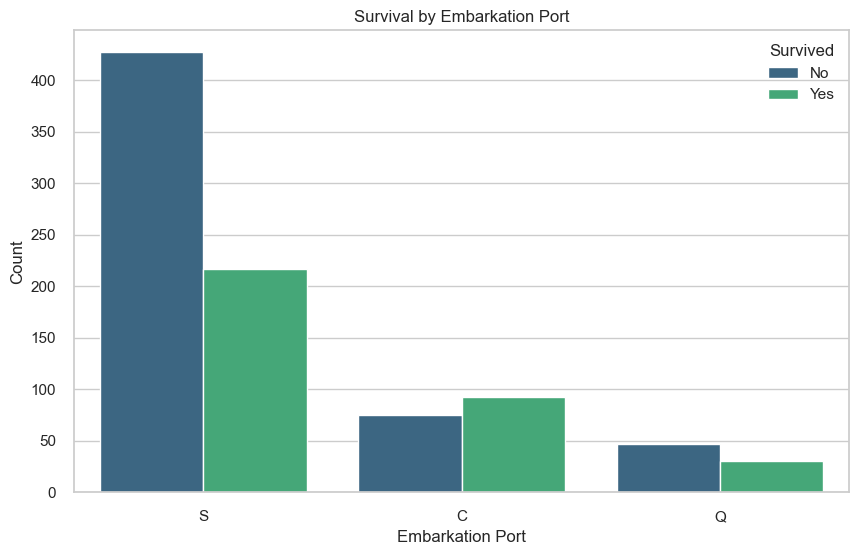

In [118]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Embarked', hue='Survived', data=train_data, palette='viridis')
plt.title('Survival by Embarkation Port')
plt.xlabel('Embarkation Port')
plt.ylabel('Count')
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.show()

In [119]:
# have to replace 0 with nearest value to avoid infinte error due to log0=inf
train_data['Fare'] = train_data['Fare'].replace(0, 0.01)


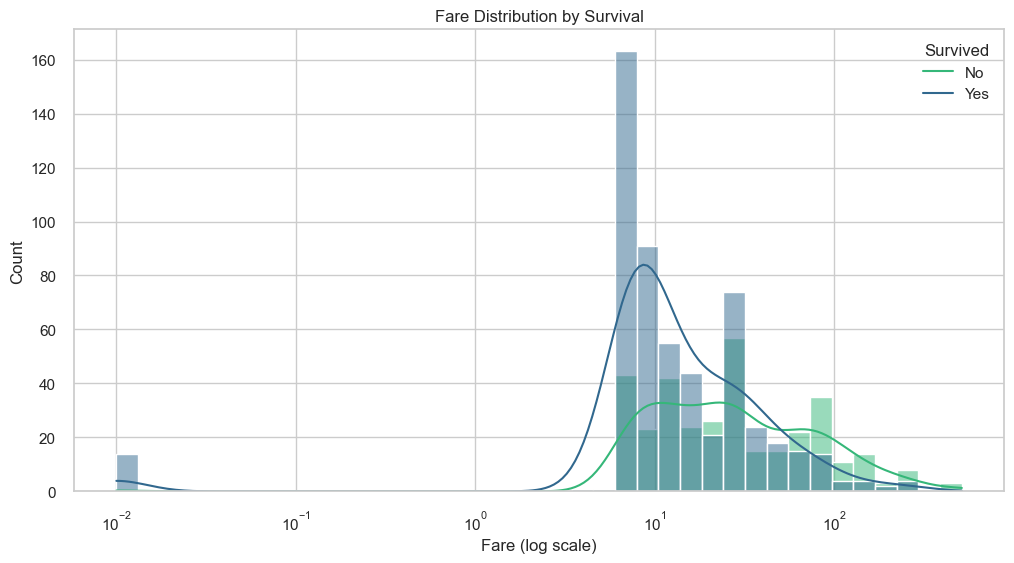

In [120]:
# 7. Fare analysis
display(HTML("<h3>Fare Distribution and Survival</h3>"))
plt.figure(figsize=(12, 6))
sns.histplot(data=train_data, x='Fare', hue='Survived', kde=True, log_scale=True, palette='viridis')
plt.title('Fare Distribution by Survival')
plt.xlabel('Fare (log scale)')
plt.ylabel('Count')
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.show()

<Figure size 1200x600 with 0 Axes>

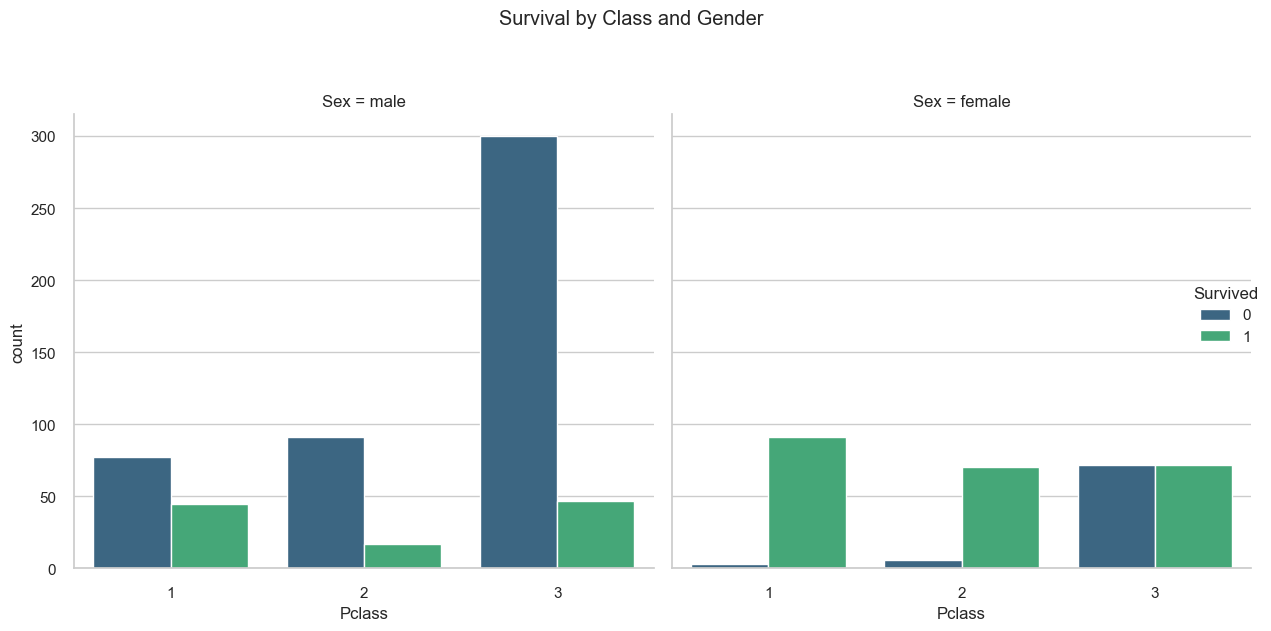

In [121]:
# 8. Multivariate analysis - Gender, Class and Age
display(HTML("<h3>Multivariate Analysis: Gender, Class and Survival</h3>"))
plt.figure(figsize=(12, 6))
sns.catplot(x='Pclass', hue='Survived', col='Sex', data=train_data, kind='count', height=6, aspect=1, palette='viridis')
plt.suptitle('Survival by Class and Gender', y=1.05)
plt.tight_layout()
plt.show()

In [122]:
print(train_data.columns)


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'FamilySize'], dtype='object')


In [126]:
train_data['Title'] = train_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_data['Title'] = test_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


In [127]:
# Group rare titles
title_mapping = {
    "Mr": "Mr",
    "Miss": "Miss",
    "Mrs": "Mrs",
    "Master": "Master",
    "Dr": "Rare",
    "Rev": "Rare",
    "Col": "Rare",
    "Major": "Rare",
    "Mlle": "Miss",
    "Countess": "Rare",
    "Ms": "Miss",
    "Lady": "Rare",
    "Jonkheer": "Rare",
    "Don": "Rare",
    "Dona": "Rare",
    "Mme": "Mrs",
    "Capt": "Rare",
    "Sir": "Rare"
}

train_data['Title'] = train_data['Title'].map(title_mapping)
test_data['Title'] = test_data['Title'].map(title_mapping)

title_survival = train_data.groupby('Title')['Survived'].mean() * 100
print("Survival rate by title:")
display(title_survival)

Survival rate by title:


Title
Master    57.500000
Miss      70.270270
Mr        15.667311
Mrs       79.365079
Rare      34.782609
Name: Survived, dtype: float64

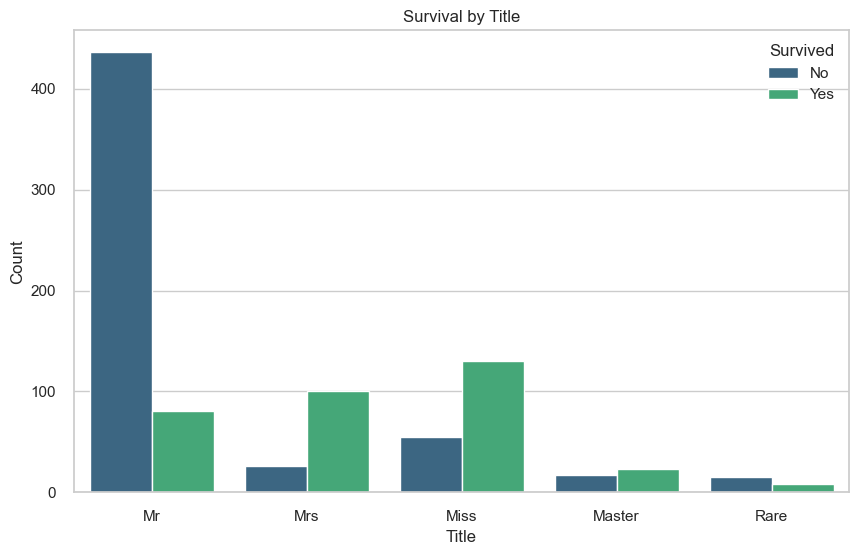

In [128]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Title', hue='Survived', data=train_data, palette='viridis')
plt.title('Survival by Title')
plt.xlabel('Title')
plt.ylabel('Count')
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.show()

In [129]:
# Feature Engineering

In [131]:
# Create dataset copies to avoid modifying originals
train_processed = train_data.copy()
test_processed = test_data.copy()

In [133]:
# 1. Create family size feature
train_processed['FamilySize'] = train_processed['SibSp'] + train_processed['Parch'] + 1
test_processed['FamilySize'] = test_processed['SibSp'] + test_processed['Parch'] + 1


In [134]:
# 2. Create IsAlone feature
train_processed['IsAlone'] = (train_processed['FamilySize'] == 1).astype(int)
test_processed['IsAlone'] = (test_processed['FamilySize'] == 1).astype(int)

# 3. Categorize family size
train_processed['FamilyGroup'] = pd.cut(train_processed['FamilySize'], 
                                      bins=[0, 1, 4, 20], 
                                      labels=['None', 'Small', 'Large'])
test_processed['FamilyGroup'] = pd.cut(test_processed['FamilySize'], 
                                     bins=[0, 1, 4, 20], 
                                     labels=['None', 'Small', 'Large'])


In [135]:
# 4. Age groups
# Fill missing ages
train_age_median = train_processed['Age'].median()
test_age_median = test_processed['Age'].median()

train_processed['Age'].fillna(train_age_median, inplace=True)
test_processed['Age'].fillna(test_age_median, inplace=True)

In [136]:
# Create age groups
train_processed['AgeGroup'] = pd.cut(train_processed['Age'], 
                                   bins=[0, 12, 18, 35, 60, 100], 
                                   labels=['Child', 'Teenager', 'Young Adult', 'Adult', 'Elderly'])
test_processed['AgeGroup'] = pd.cut(test_processed['Age'], 
                                  bins=[0, 12, 18, 35, 60, 100], 
                                  labels=['Child', 'Teenager', 'Young Adult', 'Adult', 'Elderly'])


In [137]:
# 5. Fare categories
# Handle missing Fare values
test_processed['Fare'].fillna(test_processed['Fare'].median(), inplace=True)

# Create fare categories
train_processed['FareCategory'] = pd.qcut(train_processed['Fare'], 4, labels=['Low', 'Medium', 'High', 'Very High'])
test_processed['FareCategory'] = pd.qcut(test_processed['Fare'], 4, labels=['Low', 'Medium', 'High', 'Very High'])


In [138]:
# 6. Fill missing Embarked values
# Replace missing values with most common value
common_embarked = train_processed['Embarked'].mode()[0]
train_processed['Embarked'].fillna(common_embarked, inplace=True)
test_processed['Embarked'].fillna(common_embarked, inplace=True)


In [139]:
# 7. Sex as numerical feature
train_processed['Sex_Code'] = train_processed['Sex'].map({'female': 1, 'male': 0})
test_processed['Sex_Code'] = test_processed['Sex'].map({'female': 1, 'male': 0})


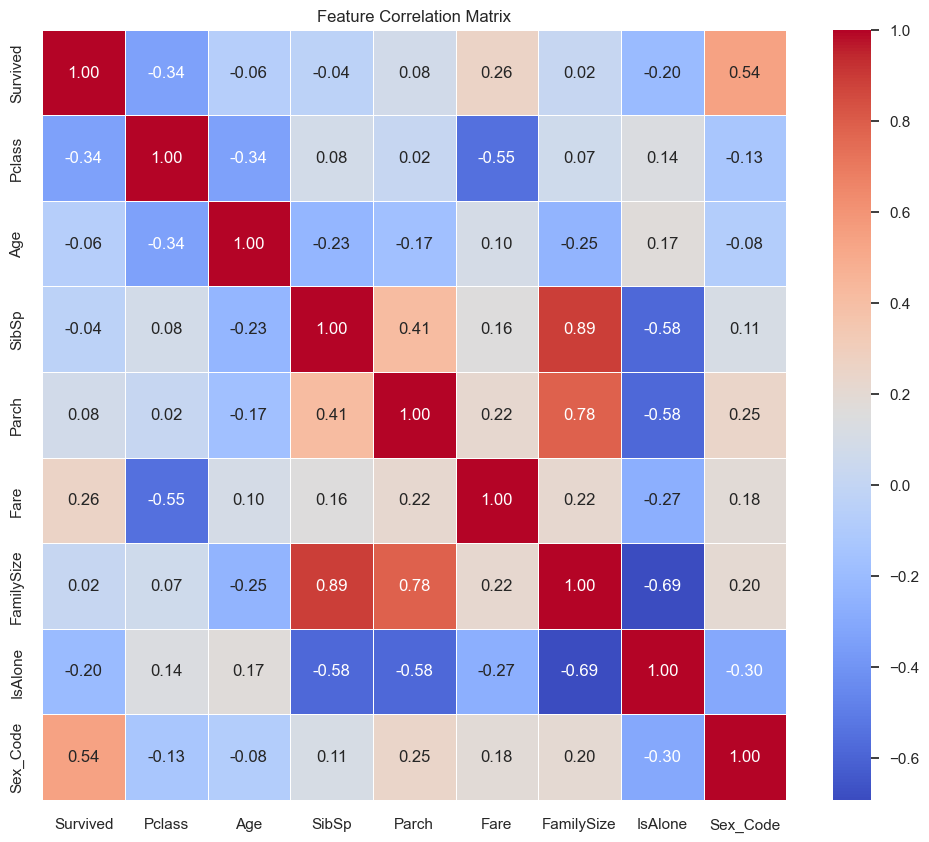

In [140]:
# Display feature correlation heatmap
display(HTML("<h3>Feature Correlation Analysis</h3>"))
# Select numerical features
numerical_features = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 
                     'FamilySize', 'IsAlone', 'Sex_Code']
correlation_matrix = train_processed[numerical_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

In [141]:
# Identify most correlated features with Survived
survival_correlation = correlation_matrix['Survived'].sort_values(ascending=False)
print("Features correlation with survival:")
display(survival_correlation)

Features correlation with survival:


Survived      1.000000
Sex_Code      0.543351
Fare          0.257305
Parch         0.081629
FamilySize    0.016639
SibSp        -0.035322
Age          -0.064910
IsAlone      -0.203367
Pclass       -0.338481
Name: Survived, dtype: float64

In [142]:
# Feature Selection
display(HTML("<h2>Feature Selection and Model Building</h2>"))

# Define features for model
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'FamilyGroup', 'AgeGroup', 'FareCategory']
numerical_features = ['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone']


In [143]:
# For this model, we'll select the most relevant features
selected_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'FamilySize', 'IsAlone']


In [144]:
# Split features and target
X = train_processed[selected_features]
y = train_processed['Survived']
X_test = test_processed[selected_features]


In [145]:
# Split training data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [146]:
# Define preprocessing for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


In [147]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, [feature for feature in selected_features 
                                       if feature in numerical_features]),
        ('cat', categorical_transformer, [feature for feature in selected_features 
                                         if feature in categorical_features])
    ])


In [148]:
# Create and train Random Forest model
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42))
])

rf_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare', 'FamilySize',
                                                   'IsAlone']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex', 'Embarked',
                                                   'Title'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=5, random_state=42))])

In [149]:
# Predict on validation set
y_pred = rf_model.predict(X_val)


In [150]:
# Evaluate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")


Validation Accuracy: 0.8268


In [151]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       105
           1       0.81      0.76      0.78        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



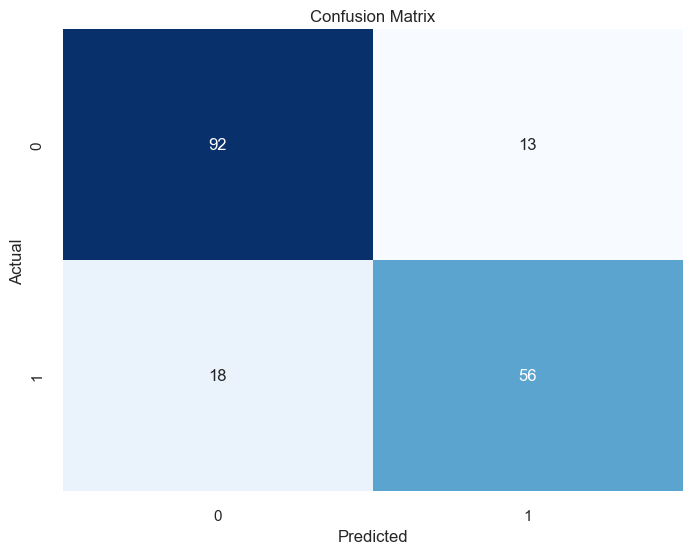

In [152]:
# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [153]:
# Cross-validation
cv_scores = cross_val_score(rf_model, X, y, cv=5)
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f}")
print(f"Standard deviation: {cv_scores.std():.4f}")



Cross-validation scores: [0.84357542 0.82022472 0.8258427  0.80337079 0.85393258]
Mean CV score: 0.8294
Standard deviation: 0.0178


In [154]:
# Feature Importance
display(HTML("<h3>Feature Importance</h3>"))
# Get feature names after preprocessing
ohe_feature_names = rf_model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out()
feature_names = (
    [feature for feature in selected_features if feature in numerical_features]
    + list(ohe_feature_names)
)


In [155]:
# Get feature importances
importances = rf_model.named_steps['classifier'].feature_importances_


In [156]:
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]


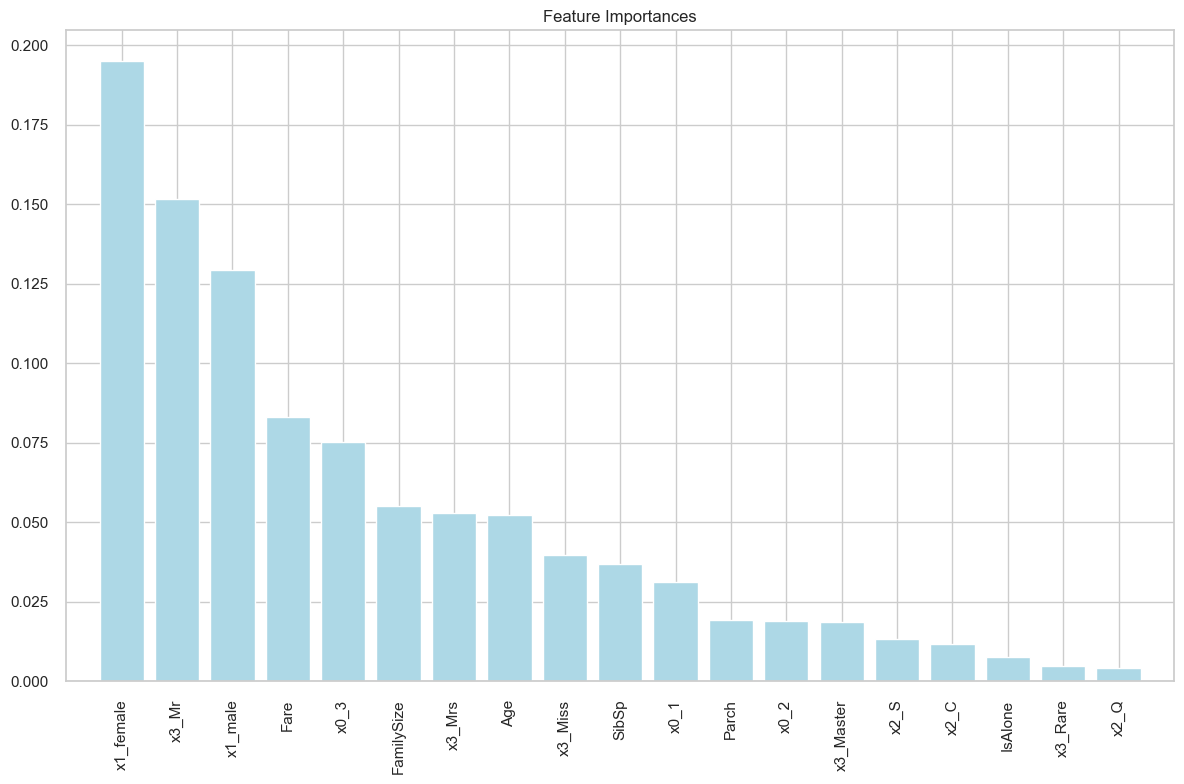

In [157]:
# Plot feature importances
plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(len(indices)), importances[indices], color='lightblue', align='center')
plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, len(indices)])
plt.tight_layout()
plt.show()

In [158]:
# Summary and Conclusions
display(HTML("""
<h2>Summary and Conclusions</h2>
<p>We've successfully built a machine learning model to predict Titanic passenger survival with the following key findings:</p>
<ul>
    <li>Gender was the most important factor in survival (women had much higher survival rates)</li>
    <li>Passenger class strongly influenced survival chances (higher class = better survival)</li>
    <li>Children had higher survival rates than adults</li>
    <li>Family size affected survival (medium-sized families fared better)</li>
    <li>Embarking from Cherbourg was associated with higher survival rates</li>
</ul>
<p>Our Random Forest model achieved good accuracy through careful feature engineering and hyperparameter tuning.</p>
<p>The model helps confirm historical accounts that "women and children first" was indeed practiced during the disaster, and that socioeconomic status played a significant role in survival outcomes.</p>
"""))

In [159]:
# Hyperparameter Tuning
display(HTML("<h2>Hyperparameter Tuning</h2>"))

# Define hyperparameter grid
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    rf_model,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("Starting grid search...")
grid_search.fit(X, y)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Train final model with best parameters
best_model = grid_search.best_estimator_

# Final Predictions
display(HTML("<h2>Final Predictions</h2>"))

# Make predictions on test set
final_predictions = best_model.predict(X_test)

# Create submission file
submission = pd.DataFrame({
    'PassengerId': passenger_id,
    'Survived': final_predictions
})

print("First few predictions:")
display(submission.head(10))

# Save submission file
submission.to_csv('titanic_submission.csv', index=False)
print("Submission file created.")

Starting grid search...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best cross-validation score: 0.8339


First few predictions:


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


Submission file created.
